<a href="https://colab.research.google.com/github/Ambuka-nuru/Data/blob/main/ChirpsPlantingDate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/drive/MyDrive/PERSONAL/Pry'
path2 = '/content/drive/MyDrive/WORK/N/Risk Profile/AEZ/aez_kithimani.geojson'

In [ ]:
import ee
service_account = 'stephen-kory@ee-stephenkorykorir.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, path1+'/params.json')
ee.Initialize(credentials)
# logging.info("Earth Engine has been successfully initialized.")
print('Initialized')

Initialized


In [ ]:
import xee
import ee
import xarray
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json

In [ ]:
def load_geojson_data(filename, feature_index):
    """Loads a GeoJSON file and returns the specified feature geometry and title."""
    with open(filename, 'r') as f:
        data = json.load(f)
    geometry = ee.Geometry.Polygon(data['features'][feature_index]['geometry']['coordinates'][0])
    title = data['features'][feature_index]['properties']['label']
    return geometry, title

In [ ]:
def calculate_rain(geom,start_date,end_date):
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterBounds(geom) \
   .filterDate(start_date,end_date)  # Adjust the date range as needed

    chirps_rain = chirps.select('precipitation')


    ds = xarray.open_dataset(chirps_rain, engine='ee', crs='EPSG:3857', scale=1000, geometry=geom, ee_mask_value=-9999)

    ds = ds.sortby('time')

    ndvi_time_series = ds.precipitation.mean(dim = ['X','Y'])
    original_time_series = ndvi_time_series.compute()
    original_time_series = original_time_series.squeeze()

    time_series_resampled = original_time_series\
    .resample(time='5d').mean(dim='time')

    time_series_interpolated = time_series_resampled\
    .interpolate_na('time', use_coordinate=False)

    # time_series_smooth = time_series_interpolated\
    # .rolling(time=10, center=True).mean()

    return dict(original_time_series=original_time_series)



In [ ]:
def plot_time_series(results, title):

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)

    results['original_time_series'].plot.line(
        ax=ax, x='time', marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)

    ax.set_title(title + ' NDVI Time Series', fontsize=14)
    ax.legend(['Original', 'Smoothed'], loc='upper left', fontsize=12)
    plt.show()

In [ ]:
import math
if __name__ == "__main__":
    filename = path2

    with open(filename, 'r') as f:
        data = json.load(f)

    num_features = len(data['features'])
     # Create an empty array to store the results
    rain = []

    start_date = '2024-08-01'
    end_date = '2025-01-01'

    for feature_index in range(num_features):
        geometry, title = load_geojson_data(filename, feature_index)
        ts = calculate_rain(geometry,start_date, end_date)
        rain.append(dict(title=title, data=ts))

In [ ]:
rain

[{'title': 2,
  'data': {'original_time_series': <xarray.DataArray 'precipitation' (time: 122)> Size: 488B
   array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          6.4352334e-01, 7.7730823e-01, 5.1012158e-01, 3.8640809e-01,
          4.5164502e-01, 1.5072644e-01, 7.9185277e-01, 3.5017231e-01,
          3.0116990e-01, 8.0676481e-02, 2.4846683e-01, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00

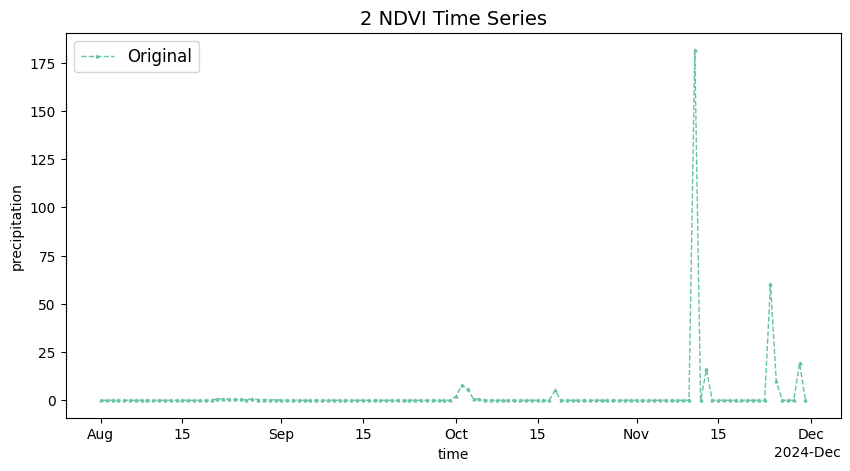

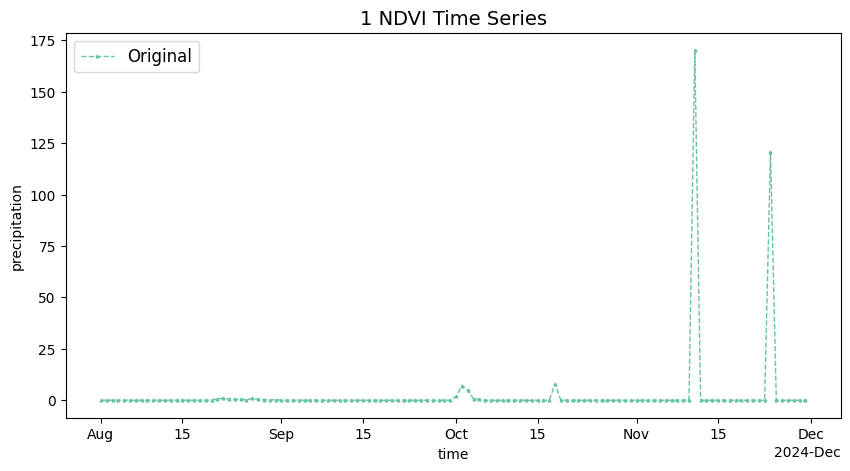

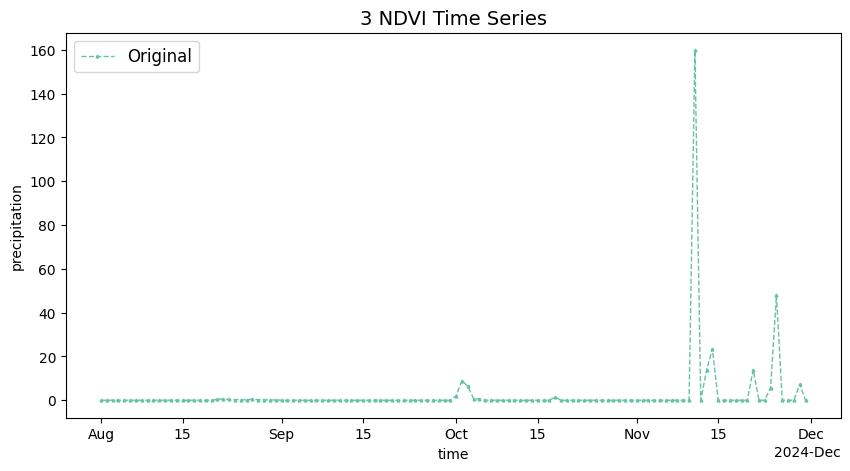

In [ ]:
#plot time series data
for i in range(len(rain)):
  plot_time_series(rain[i]['data'], str(rain[i]['title']))

In [ ]:
res = pd.DataFrame(rain)

In [ ]:
dataframes = []
for i, row in res.iterrows():
  # print(row['title'])
  # break

    dt = res['data'][i]['original_time_series'].to_dataframe()
    title = row['title']
    dt.columns = [title]
    dataframes.append(dt)

combined_df = pd.concat(dataframes, axis=1, ignore_index=False)

In [ ]:
combined_df.head(30)

,2,1,3
time,,,
2024-08-01,0.000000,0.000000,0.000000
2024-08-02,0.000000,0.000000,0.000000
2024-08-03,0.000000,0.000000,0.000000
2024-08-04,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000
2024-08-06,0.000000,0.000000,0.000000
2024-08-07,0.000000,0.000000,0.000000
2024-08-08,0.000000,0.000000,0.000000
2024-08-09,0.000000,0.000000,0.000000


In [ ]:
df_averaged = combined_df.groupby(axis=1, level=0).mean()

# Resulting DataFrame
print(df_averaged)


              1          2         3
time                                
2024-08-01  0.0   0.000000  0.000000
2024-08-02  0.0   0.000000  0.000000
2024-08-03  0.0   0.000000  0.000000
2024-08-04  0.0   0.000000  0.000000
2024-08-05  0.0   0.000000  0.000000
...         ...        ...       ...
2024-11-26  0.0   0.000000  0.000000
2024-11-27  0.0   0.000000  0.000000
2024-11-28  0.0   0.000000  0.000000
2024-11-29  0.0  19.141453  7.291982
2024-11-30  0.0   0.000000  0.000000

[122 rows x 3 columns]


<ipython-input-22-ea60fdc68236>:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_averaged = combined_df.groupby(axis=1, level=0).mean()


In [ ]:
window_size = 15
cumulative_sums = df_averaged.rolling(window=window_size).sum()
df_columns = cumulative_sums.columns.values
print(cumulative_sums)

                     1          2           3
time                                         
2024-08-01         NaN        NaN         NaN
2024-08-02         NaN        NaN         NaN
2024-08-03         NaN        NaN         NaN
2024-08-04         NaN        NaN         NaN
2024-08-05         NaN        NaN         NaN
...                ...        ...         ...
2024-11-26  120.771484  86.276999  104.664612
2024-11-27  120.771484  86.276999  104.664612
2024-11-28  120.771484  70.315831   90.983610
2024-11-29  120.771484  89.457284   74.811323
2024-11-30  120.771484  89.457284   74.811323

[122 rows x 3 columns]


In [ ]:
cumulative_sums.head(50)

,1,2,3
time,,,
2024-08-01,NaN,NaN,NaN
2024-08-02,NaN,NaN,NaN
2024-08-03,NaN,NaN,NaN
2024-08-04,NaN,NaN,NaN
2024-08-05,NaN,NaN,NaN
2024-08-06,NaN,NaN,NaN
2024-08-07,NaN,NaN,NaN
2024-08-08,NaN,NaN,NaN
2024-08-09,NaN,NaN,NaN


In [ ]:
for i in df_columns:
  for time, value in cumulative_sums[i].items():
    print(time, value)
    break
  break

2024-08-01 00:00:00 nan


In [ ]:
from tables import index
# Define the target number you want to find
target_number = 80

tabl = []

# Loop through the DataFrame column 'Value' to find the target number and break the loop
for i in df_columns:
  for time, value in cumulative_sums[i].items():
      # print(time)



      if (value >= target_number):
          arr = [time,i]
          tabl.append(arr)
          break
      # else:
      #     # print("Current value:", value)
df_dop = pd.DataFrame(tabl, columns=['Plantin_date','AEZ'])
print(df_dop.head())

  Plantin_date  AEZ
0   2024-11-11    1
1   2024-11-11    2
2   2024-11-11    3
